# Finetuning and feature extraction of Convnet

[This notebbok was referred from here.](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

### Dependencies

Cloning the Git repo which has the dataset

In [ ]:
!pip install torch torchvision
!pip install Pillow==4.0.0

!git clone https://rathan_dev@bitbucket.org/rathan_dev/transfer_learning_dataset-1.git

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60e36000 @  0x7fe59e4f32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 23.0MB/s 
    100% |████████████████████████████████| 2.0MB 4.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 7.3MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
Cloning into 'transfer_learning_dataset-1'...
remote: Counting objects: 410, done.


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

### Load and augment data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# Loading data

data_dir = 'transfer_learning_dataset-1/hymenoptera_data'
image_datasets = {i: datasets.ImageFolder(os.path.join(data_dir, i),data_transforms[i])
                  for i in ['train', 'val']}
dataloaders = {i: torch.utils.data.DataLoader
               (image_datasets[i], batch_size=4, shuffle=True, num_workers=4)
              for i in ['train', 'val']}
dataset_sizes = {i: len(image_datasets[i]) for i in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize images from dataset

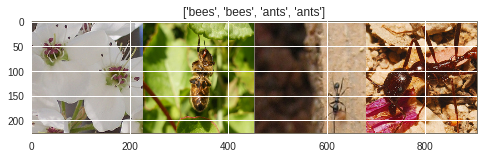

In [ ]:
# Visualize few images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[i] for i in classes])

### TRAINING THE MODEL

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### FINETUNING THE CONVNET

In [ ]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 69764631.16it/s]


### Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.3665 Acc: 0.8197
val Loss: 0.1864 Acc: 0.9346

Epoch 1/49
----------
train Loss: 0.4731 Acc: 0.7828
val Loss: 0.1571 Acc: 0.9542

Epoch 2/49
----------
train Loss: 0.3140 Acc: 0.8484
val Loss: 0.1671 Acc: 0.9608

Epoch 3/49
----------
train Loss: 0.3766 Acc: 0.8402
val Loss: 0.1640 Acc: 0.9542

Epoch 4/49
----------
train Loss: 0.5082 Acc: 0.7582
val Loss: 0.1830 Acc: 0.9346

Epoch 5/49
----------
train Loss: 0.4000 Acc: 0.8074
val Loss: 0.1654 Acc: 0.9542

Epoch 6/49
----------
train Loss: 0.4452 Acc: 0.8074
val Loss: 0.1616 Acc: 0.9542

Epoch 7/49
----------
train Loss: 0.4182 Acc: 0.7992
val Loss: 0.1840 Acc: 0.9412

Epoch 8/49
----------
train Loss: 0.4473 Acc: 0.8238
val Loss: 0.1664 Acc: 0.9477

Epoch 9/49
----------
train Loss: 0.4368 Acc: 0.8074
val Loss: 0.1582 Acc: 0.9542

Epoch 10/49
----------
train Loss: 0.3628 Acc: 0.8607
val Loss: 0.1655 Acc: 0.9542

Epoch 11/49
----------
train Loss: 0.4542 Acc: 0.7869
val Loss: 0.1638 Acc: 0.9542

Ep

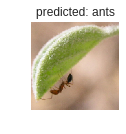

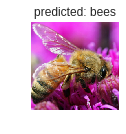

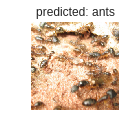

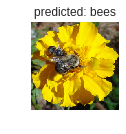

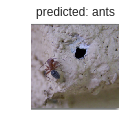

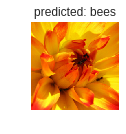

In [ ]:
visualize_model(model_ft)

### CONVNET AS FIXED FEATURE EXTRACTOR

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5580 Acc: 0.6844
val Loss: 0.2810 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5222 Acc: 0.7336
val Loss: 0.2249 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.5626 Acc: 0.7828
val Loss: 0.2224 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4837 Acc: 0.8074
val Loss: 0.2424 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4477 Acc: 0.8033
val Loss: 0.2886 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.4862 Acc: 0.8033
val Loss: 0.2512 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6309 Acc: 0.7418
val Loss: 0.2164 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.4184 Acc: 0.7951
val Loss: 0.2338 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3216 Acc: 0.8689
val Loss: 0.2332 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3723 Acc: 0.8361
val Loss: 0.2804 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.3049 Acc: 0.8648
val Loss: 0.2251 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3536 Acc: 0.8566
val Loss: 0.2156 Acc: 0.9477

Ep

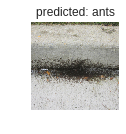

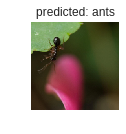

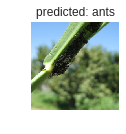

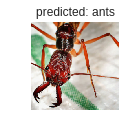

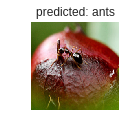

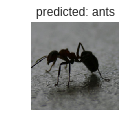

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()